In [49]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Flatten
import tensorflow as tf

In [4]:
# Define path for file with sonnets
CHAIRIL_FILE = './chairil_anwar.txt'

# Read the data
with open('./chairil_anwar.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of chairil anwar\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
    print(corpus[i])

There are 363 lines of chairil anwar

The first 5 lines look like this:

kalau sampai waktuku
'ku mau tak seorang'kan merayu
tidak juga kau
tak perlu sedu sedan itu
aku ini binatang jalang


In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [6]:
corpus[0]

'kalau sampai waktuku'

In [7]:
tokenizer.texts_to_sequences(corpus[0])

[[614],
 [],
 [613],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [614],
 [],
 [],
 [614],
 []]

In [8]:
tokenizer.texts_to_sequences([corpus[0]])

[[33, 113, 223]]

In [9]:
tokenizer.texts_to_sequences([corpus[0]])[0]

[33, 113, 223]

In [10]:
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences

    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary

    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []

    ### START CODE HERE
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]

        for i in range (1, len(token_list)):
            n_gram_sequences = token_list[:i+1]

            input_sequences.append(n_gram_sequences)

    ### END CODE HERE

    return input_sequences

In [11]:
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[33, 113], [33, 113, 223]]

In [12]:
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[[224, 17],
 [224, 17, 3],
 [224, 17, 3, 225],
 [224, 17, 3, 225, 226],
 [21, 27],
 [21, 27, 6],
 [3, 227],
 [3, 227, 228],
 [3, 227, 228, 229],
 [3, 227, 228, 229, 10]]

In [13]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 1102
maximum length of sequences is: 9


In [14]:
def pad_seqs(input_sequences, maxlen):
    """
    Pads tokenized sequences to the same length

    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences

    Returns:
        padded_sequences (array of int): tokenized sequences padded to the same length
    """
    ### START CODE HERE
    padded_sequences = pad_sequences(input_sequences, maxlen=maxlen)

    return padded_sequences

In [15]:
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[  0,  33, 113],
       [ 33, 113, 223]], dtype=int32)

In [16]:
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[  0,   0,   0, 224,  17],
       [  0,   0, 224,  17,   3],
       [  0, 224,  17,   3, 225],
       [224,  17,   3, 225, 226],
       [  0,   0,   0,  21,  27],
       [  0,   0,  21,  27,   6],
       [  0,   0,   0,   3, 227],
       [  0,   0,   3, 227, 228],
       [  0,   3, 227, 228, 229],
       [  3, 227, 228, 229,  10]], dtype=int32)

In [17]:
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (1102, 9)


In [18]:
def features_and_labels(input_sequences, total_words):
    """
    Generates features and labels from n-grams

    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size

    Returns:
        features, one_hot_labels (array of int, array of int): arrays of features and one-hot encoded labels
    """
    ### START CODE HERE
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)
    ### END CODE HERE

    return features, one_hot_labels

In [19]:
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (2, 771)

features look like this:



array([[  0,  33],
       [ 33, 113]], dtype=int32)

In [20]:
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (1102, 8)
labels have shape: (1102, 771)


In [55]:
def create_model(total_words, max_sequence_len):
    """
    Creates a text generator model

    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text generator model
    """
    model = Sequential()
    ### START CODE HERE
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(150, return_sequences= True)))
    model.add(Bidirectional(LSTM(128)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(total_words, activation='softmax'))


    # Compile the model
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

    ### END CODE HERE

    return model

In [56]:
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') is not None and logs.get('accuracy') > 0.85:                 
                print("\nReached 85% accuracy so cancelling training!")
                
                # Stop training once the above condition is met
                self.model.stop_training = True

In [57]:
callbacks = myCallback()
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=500)

Epoch 1/500
35/35 [==============================] - 4s 22ms/step - loss: 6.6306 - accuracy: 0.0073
Epoch 2/500
35/35 [==============================] - 1s 25ms/step - loss: 6.4208 - accuracy: 0.0109
Epoch 3/500
35/35 [==============================] - 1s 25ms/step - loss: 6.2472 - accuracy: 0.0200
Epoch 4/500
35/35 [==============================] - 1s 26ms/step - loss: 6.1244 - accuracy: 0.0145
Epoch 5/500
35/35 [==============================] - 1s 24ms/step - loss: 5.9955 - accuracy: 0.0200
Epoch 6/500
35/35 [==============================] - 1s 26ms/step - loss: 5.8614 - accuracy: 0.0181
Epoch 7/500
35/35 [==============================] - 1s 32ms/step - loss: 5.7639 - accuracy: 0.0127
Epoch 8/500
35/35 [==============================] - 1s 25ms/step - loss: 5.6962 - accuracy: 0.0191
Epoch 9/500
35/35 [==============================] - 1s 24ms/step - loss: 5.6093 - accuracy: 0.0191
Epoch 10/500
35/35 [==============================] - 1s 24ms/step - loss: 5.5468 - accuracy: 0.0245

35/35 [==============================] - 1s 26ms/step - loss: 1.3954 - accuracy: 0.5726
Epoch 83/500
35/35 [==============================] - 1s 25ms/step - loss: 1.4299 - accuracy: 0.5472
Epoch 84/500
35/35 [==============================] - 1s 25ms/step - loss: 1.3860 - accuracy: 0.5835
Epoch 85/500
35/35 [==============================] - 1s 25ms/step - loss: 1.3637 - accuracy: 0.5935
Epoch 86/500
35/35 [==============================] - 1s 25ms/step - loss: 1.3309 - accuracy: 0.5644
Epoch 87/500
35/35 [==============================] - 1s 25ms/step - loss: 1.3527 - accuracy: 0.5699
Epoch 88/500
35/35 [==============================] - 1s 25ms/step - loss: 1.2879 - accuracy: 0.5962
Epoch 89/500
35/35 [==============================] - 1s 24ms/step - loss: 1.2351 - accuracy: 0.6216
Epoch 90/500
35/35 [==============================] - 1s 26ms/step - loss: 1.2455 - accuracy: 0.6044
Epoch 91/500
35/35 [==============================] - 1s 25ms/step - loss: 1.1468 - accuracy: 0.6543
Epo

35/35 [==============================] - 1s 26ms/step - loss: 0.5602 - accuracy: 0.8022
Epoch 163/500
35/35 [==============================] - 1s 25ms/step - loss: 0.5972 - accuracy: 0.7958
Epoch 164/500
35/35 [==============================] - 1s 32ms/step - loss: 0.5247 - accuracy: 0.8094
Epoch 165/500
35/35 [==============================] - 1s 28ms/step - loss: 0.5569 - accuracy: 0.8058
Epoch 166/500
35/35 [==============================] - 1s 24ms/step - loss: 0.5436 - accuracy: 0.8113
Epoch 167/500
35/35 [==============================] - 1s 25ms/step - loss: 0.5856 - accuracy: 0.7995
Epoch 168/500
35/35 [==============================] - 1s 25ms/step - loss: 0.5666 - accuracy: 0.7949
Epoch 169/500
35/35 [==============================] - 1s 25ms/step - loss: 0.5156 - accuracy: 0.8122
Epoch 170/500
35/35 [==============================] - 1s 25ms/step - loss: 0.5480 - accuracy: 0.8113
Epoch 171/500
35/35 [==============================] - 1s 25ms/step - loss: 0.5020 - accuracy: 0

35/35 [==============================] - 1s 34ms/step - loss: 0.4442 - accuracy: 0.8240
Epoch 243/500
35/35 [==============================] - 1s 27ms/step - loss: 0.4615 - accuracy: 0.8221
Epoch 244/500
35/35 [==============================] - 1s 27ms/step - loss: 0.4867 - accuracy: 0.8230
Epoch 245/500
35/35 [==============================] - 1s 28ms/step - loss: 0.4943 - accuracy: 0.8149
Epoch 246/500
35/35 [==============================] - 1s 26ms/step - loss: 0.4581 - accuracy: 0.8212
Epoch 247/500
35/35 [==============================] - 1s 26ms/step - loss: 0.5308 - accuracy: 0.8103
Epoch 248/500
35/35 [==============================] - 1s 26ms/step - loss: 0.5371 - accuracy: 0.7995
Epoch 249/500
35/35 [==============================] - 1s 25ms/step - loss: 0.5033 - accuracy: 0.8167
Epoch 250/500
35/35 [==============================] - 1s 27ms/step - loss: 0.4545 - accuracy: 0.8212
Epoch 251/500
35/35 [==============================] - 1s 30ms/step - loss: 0.4368 - accuracy: 0

35/35 [==============================] - 1s 25ms/step - loss: 0.3898 - accuracy: 0.8376
Epoch 323/500
35/35 [==============================] - 1s 25ms/step - loss: 0.3886 - accuracy: 0.8412
Epoch 324/500
35/35 [==============================] - 1s 25ms/step - loss: 0.3850 - accuracy: 0.8376
Epoch 325/500
35/35 [==============================] - 1s 25ms/step - loss: 0.4176 - accuracy: 0.8339
Epoch 326/500
35/35 [==============================] - 1s 26ms/step - loss: 0.3978 - accuracy: 0.8403
Epoch 327/500
35/35 [==============================] - 1s 24ms/step - loss: 0.4105 - accuracy: 0.8303
Epoch 328/500
35/35 [==============================] - 1s 24ms/step - loss: 0.3956 - accuracy: 0.8358
Epoch 329/500
35/35 [==============================] - 1s 26ms/step - loss: 0.4038 - accuracy: 0.8376
Epoch 330/500
35/35 [==============================] - 1s 26ms/step - loss: 0.3882 - accuracy: 0.8348
Epoch 331/500
35/35 [==============================] - 1s 26ms/step - loss: 0.3706 - accuracy: 0

35/35 [==============================] - 1s 28ms/step - loss: 0.4040 - accuracy: 0.8485
Epoch 403/500
35/35 [==============================] - 1s 26ms/step - loss: 0.3854 - accuracy: 0.8457
Epoch 404/500
35/35 [==============================] - 1s 25ms/step - loss: 0.4047 - accuracy: 0.8330
Epoch 405/500
35/35 [==============================] - 1s 26ms/step - loss: 0.4545 - accuracy: 0.8267
Epoch 406/500
35/35 [==============================] - 1s 29ms/step - loss: 0.4109 - accuracy: 0.8367
Epoch 407/500
35/35 [==============================] - 1s 31ms/step - loss: 0.4117 - accuracy: 0.8321
Epoch 408/500
35/35 [==============================] - 1s 25ms/step - loss: 0.4419 - accuracy: 0.8312
Epoch 409/500
35/35 [==============================] - 1s 26ms/step - loss: 0.4284 - accuracy: 0.8303
Epoch 410/500
35/35 [==============================] - 1s 27ms/step - loss: 0.3991 - accuracy: 0.8339
Epoch 411/500
35/35 [==============================] - 1s 25ms/step - loss: 0.4002 - accuracy: 0

35/35 [==============================] - 1s 32ms/step - loss: 0.3620 - accuracy: 0.8421
Epoch 483/500
35/35 [==============================] - 1s 28ms/step - loss: 0.3501 - accuracy: 0.8539
Epoch 484/500
35/35 [==============================] - 1s 29ms/step - loss: 0.3546 - accuracy: 0.8494
Epoch 485/500
35/35 [==============================] - 1s 25ms/step - loss: 0.3664 - accuracy: 0.8439
Epoch 486/500
35/35 [==============================] - 1s 30ms/step - loss: 0.3913 - accuracy: 0.8439
Epoch 487/500
35/35 [==============================] - 1s 29ms/step - loss: 0.4087 - accuracy: 0.8367
Epoch 488/500
35/35 [==============================] - 1s 30ms/step - loss: 0.3927 - accuracy: 0.8367
Epoch 489/500
35/35 [==============================] - 1s 41ms/step - loss: 0.3852 - accuracy: 0.8439
Epoch 490/500
35/35 [==============================] - 1s 30ms/step - loss: 0.3779 - accuracy: 0.8439
Epoch 491/500
35/35 [==============================] - 1s 33ms/step - loss: 0.3745 - accuracy: 0

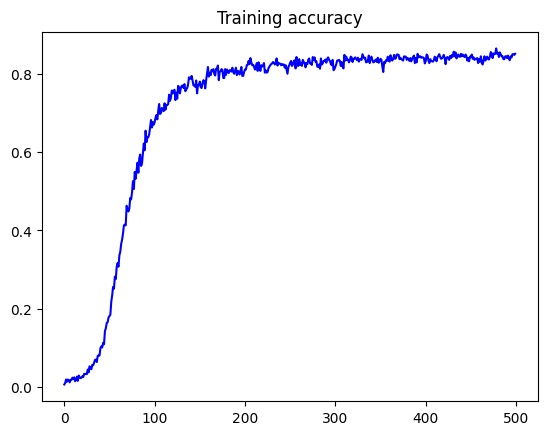

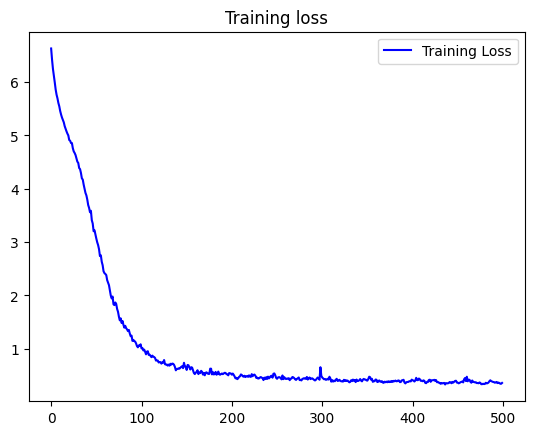

In [58]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [59]:
seed_text = "Kalau sampai waktuku 'Ku mau tak seorang'kan merayu"
next_words = 50

for _ in range(next_words):
    # Convert the text into sequences
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # Pad the sequences
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted = model.predict(token_list, verbose=0)
    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()
    # Get the actual word from the word index
    output_word = tokenizer.index_word[predicted]
    # Append to the current text
    seed_text += " " + output_word

print(seed_text)

Kalau sampai waktuku 'Ku mau tak seorang'kan merayu 'nusia sorga awan awan saja purnama raya menembus 'nusia awan awan menyala kapur saja purnama raya menembus 'nusia awan awan menyala kapur saja purnama raya menembus 'nusia awan awan menyala kapur saja purnama raya menembus 'nusia awan awan menyala kapur saja purnama raya menembus 'nusia awan awan menyala kapur saja
